In [61]:
# -*- coding: utf-8 -*-
"""
Created on 2023-10-10

@author: ivespe

Intro script for Exercise 4 ("Battery energy storage system in the grid vs. grid investments") 
in specialization course module "Flexibility in power grid operation and planning" 
at NTNU (TET4565/TET4575) 

"""


# %% Dependencies

import pandas as pd
import os
import load_profiles as lp
import pandapower_read_csv as ppcsv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# %% Define input data

# Location of (processed) data set for CINELDI MV reference system
# (to be replaced by your own local data folder)
path_data_set         = 'C:/Users/benny/Downloads/Cineldi/Data'

filename_load_data_fullpath = os.path.join(path_data_set,'load_data_CINELDI_MV_reference_system.csv')
filename_load_mapping_fullpath = os.path.join(path_data_set,'mapping_loads_to_CINELDI_MV_reference_grid.csv')
filename_standard_overhead_lines = os.path.join(path_data_set,'standard_overhead_line_types.csv')
filename_reldata = os.path.join(path_data_set,'reldata_for_component_types.csv')
filename_load_point = os.path.join(path_data_set,'CINELDI_MV_reference_system_load_point.csv')

# Subset of load buses to consider in the grid area, considering the area at the end of the main radial in the grid
bus_i_subset = [90, 91, 92, 96]

# Assumed power flow limit in MW that limit the load demand in the grid area (through line 85-86)
P_lim = 4

# Factor to scale the loads for this exercise compared with the base version of the CINELDI reference system data set
scaling_factor = 10

# Read standard data for overhead lines
data_standard_overhead_lines = pd.read_csv(filename_standard_overhead_lines, delimiter=';')
data_standard_overhead_lines.set_index(keys = 'type', drop = True, inplace = True)

# Read standard component reliability data
data_comp_rel = pd.read_csv(filename_reldata, delimiter=';')
data_comp_rel.set_index(keys = 'main_type', drop = True, inplace = True)

# Read load point data (incl. specific rates of costs of energy not supplied) for data
data_load_point = pd.read_csv(filename_load_point, delimiter=';')
data_load_point.set_index(keys = 'bus_i', drop = True, inplace = True)


# %% Read pandapower network

net = ppcsv.read_net_from_csv(path_data_set, baseMVA=10)


# %% Set up hourly normalized load time series for a representative day (task 2; this code is provided to the students)

load_profiles = lp.load_profiles(filename_load_data_fullpath)

# Consider only the day with the peak load in the area (28 February)
repr_days = [31+28]

# Get relative load profiles for representative days mapped to buses of the CINELDI test network;
# the column index is the bus number (1-indexed) and the row index is the hour of the year (0-indexed)
profiles_mapped = load_profiles.map_rel_load_profiles(filename_load_mapping_fullpath,repr_days)

# Calculate load time series in units MW (or, equivalently, MWh/h) by scaling the normalized load time series by the
# maximum load value for each of the load points in the grid data set (in units MW); the column index is the bus number
# (1-indexed) and the row index is the hour of the year (0-indexed)
load_time_series_mapped = profiles_mapped.mul(net.load['p_mw'])


# %% Aggregate the load demand in the area

# Aggregated load time series for the subset of load buses
load_time_series_subset = load_time_series_mapped[bus_i_subset] * scaling_factor
load_time_series_subset_aggr = load_time_series_subset.sum(axis=1)

P_max = load_time_series_subset_aggr.max()


c:\Users\benny\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


## Task 2

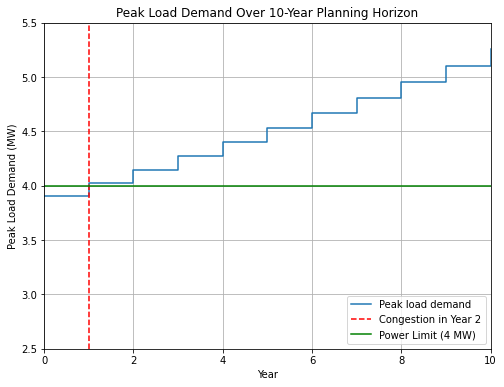

Congestion occurs in Year 2, at which point measures need to be implemented.


In [62]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
years = []
peak_loads = []

# Iterate through the 10-year planning horizon
for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset * yearly_scaling_factor
    
    # Calculate the peak load demand for this year
    peak_load = scaled_load_time_series.sum(axis=1).max()

    # Append the year and peak load to the lists
    years.append(year)
    peak_loads.append(peak_load)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(years, peak_loads, linestyle='-', label="Peak load demand", drawstyle="steps-post")
plt.xlabel("Year")
plt.ylabel("Peak Load Demand (MW)")
plt.title("Peak Load Demand Over 10-Year Planning Horizon")
plt.grid(True)

# Identify the year when congestion occurs
congestion_year = np.where(np.array(peak_loads) > P_lim)[0][0]
plt.axvline(congestion_year, color='red', linestyle='--', label=f"Congestion in Year {congestion_year+1}")
plt.axhline(P_lim, color='green', linestyle='-', label="Power Limit (4 MW)")


plt.xlim(0, 10)
plt.ylim(2.5, 5.5)

plt.legend()
plt.show()

print(f"Congestion occurs in Year {congestion_year+1}, at which point measures need to be implemented.")


## Task 3

In [63]:
l = 20  #km

# Assuming no residual value or decommissioning costs for the old line,
cost_new_line = 759408*l



print(f"Investment cost of the new line (FeAl 70): {cost_new_line} NOK per kilometer")

Investment cost of the new line (FeAl 70): 15188160 NOK per kilometer


## Task 4

In [64]:
# Define the discount rate and the number of years into the future
discount_rate = 0.04  # 4% as a decimal
years_into_future = 1  # Since we're calculating the present value at the beginning of year 2 = end of year 1

# Calculate the present value
def PresentValue(cost,discount_rate,years):
    return cost / (1 + discount_rate) ** years


present_value = PresentValue(cost_new_line,discount_rate,years_into_future)


# Display the present value
print(f"Present value of the investment costs: {present_value:.2f} NOK per kilometer")


Present value of the investment costs: 14604000.00 NOK per kilometer


## Task 5

In [65]:
# Define the economic lifetime of the new line (in years)
economic_lifetime = 40

# Define the number of years into the future (20 years analysis horizon)
years_into_future = 20

# Calculate the residual value of the new line after 20 years
# The residual value is the remaining economic life, expressed as a fraction of the initial investment cost.
residual_value = (economic_lifetime - years_into_future) / economic_lifetime * cost_new_line

# Calculate the present value of the residual value
present_value_residual_value = PresentValue(residual_value,discount_rate,years_into_future)
present_value_investment     = PresentValue(cost_new_line,discount_rate,years_into_future)



# Calculate the present value of the investment cost corrected for the residual value
present_value_corrected = present_value_investment - present_value_residual_value

# Display the results
print(f"Residual value of the new line after 20 years: {residual_value:.2f} NOK")
print(f"Present value of the residual value: {present_value_residual_value:.2f} NOK")
print(f"Present value of the investment: {present_value_investment:.2f} NOK")
print(f"Present value of the investment cost corrected for the residual value: {present_value_corrected:.2f} NOK")


Residual value of the new line after 20 years: 7594080.00 NOK
Present value of the residual value: 3465838.98 NOK
Present value of the investment: 6931677.96 NOK
Present value of the investment cost corrected for the residual value: 3465838.98 NOK


## Task 6

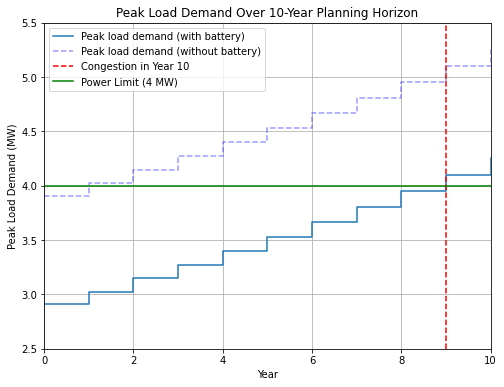

Congestion occurs in Year 10, at which point measures need to be implemented.


In [66]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
years = []
peak_loads = []

congestion_year = None
battery_power_capacity = 1  # MW
battery_energy_capacity = 2  # MWh
investment_costs = []  # To store present value of grid investments


# Iterate through the 10-year planning horizon
for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset * yearly_scaling_factor
    
    # Calculate the peak load demand for this year
    peak_load = scaled_load_time_series.sum(axis=1).max() - battery_power_capacity

    # Append the year and peak load to the lists
    years.append(year)
    peak_loads.append(peak_load)


transparent_peak_loads = [peak_load + battery_power_capacity for peak_load in peak_loads]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(years, peak_loads, linestyle='-', label="Peak load demand (with battery)", drawstyle="steps-post")
plt.plot(years, transparent_peak_loads, linestyle='--', alpha=0.4, color='blue', label="Peak load demand (without battery)",drawstyle="steps-post")
plt.xlabel("Year")
plt.ylabel("Peak Load Demand (MW)")
plt.title("Peak Load Demand Over 10-Year Planning Horizon")
plt.grid(True)

# Identify the year when congestion occurs
congestion_year = np.where(np.array(peak_loads) > P_lim)[0][0]
plt.axvline(congestion_year, color='red', linestyle='--', label=f"Congestion in Year {congestion_year+1}")
plt.axhline(P_lim, color='green', linestyle='-', label="Power Limit (4 MW)")


plt.xlim(0, 10)
plt.ylim(2.5, 5.5)

plt.legend()
plt.show()

print(f"Congestion occurs in Year {congestion_year+1}, at which point measures need to be implemented.")

In [67]:
##Recalculating the present value of grid investments now that the year is changed from 1 to 9

# Define the discount rate and the number of years into the future
discount_rate = 0.04  # 4% as a decimal
years_into_future = 9  # Since we're calculating the present value at the beginning of year 10 = end of year 9

# Calculate the present value
def PresentValue(cost,discount_rate,years):
    return cost / (1 + discount_rate) ** years


present_value = PresentValue(cost_new_line,discount_rate,years_into_future)


# Display the present value
print(f"Present value of the investment costs: {present_value:.2f} NOK per kilometer")

# Define the economic lifetime of the new line (in years)
economic_lifetime = 40

# Define the number of years into the future (20 years analysis horizon)
years_into_future = 20

# Calculate the residual value of the new line after 20 years
# The residual value is the remaining economic life, expressed as a fraction of the initial investment cost.
residual_value = (economic_lifetime - years_into_future) / economic_lifetime * cost_new_line

# Calculate the present value of the residual value
present_value_residual_value = PresentValue(residual_value,discount_rate,years_into_future)
present_value_investment     = PresentValue(cost_new_line,discount_rate,years_into_future)



# Calculate the present value of the investment cost corrected for the residual value
present_value_corrected = present_value_investment - present_value_residual_value

# Display the results
print(f"Residual value of the new line after 20 years: {residual_value:.2f} NOK")
print(f"Present value of the residual value: {present_value_residual_value:.2f} NOK")
print(f"Present value of the investment: {present_value_investment:.2f} NOK")
print(f"Present value of the investment cost corrected for the residual value: {present_value_corrected:.2f} NOK")


Present value of the investment costs: 10670999.75 NOK per kilometer
Residual value of the new line after 20 years: 7594080.00 NOK
Present value of the residual value: 3465838.98 NOK
Present value of the investment: 6931677.96 NOK
Present value of the investment cost corrected for the residual value: 3465838.98 NOK


## Task 7

In [68]:
exceeding_power = []

p_MWH = 2000
days = 20

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1+ 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = load_time_series_subset * yearly_scaling_factor

    if scaled_load_time_series.sum(axis=1).max() > P_lim:
        exceeding_power.append(scaled_load_time_series.sum(axis=1).max() - P_lim)
    else:
        exceeding_power.append(0)


ACT_costs_B = []    
for year in range(11): 
    costs = exceeding_power[year] * days * p_MWH
    ACT_costs_B.append(costs)
    print(f"Costs for exceeding power amount of", exceeding_power[year] ,"in year", year, "was equal to:",ACT_costs_B[year])


Costs for exceeding power amount of 0 in year 0 was equal to: 0
Costs for exceeding power amount of 0.026135131932091937 in year 1 was equal to: 1045.4052772836776
Costs for exceeding power amount of 0.14691918589005404 in year 2 was equal to: 5876.767435602162
Costs for exceeding power amount of 0.2713267614667565 in year 3 was equal to: 10853.07045867026
Costs for exceeding power amount of 0.39946656431075933 in year 4 was equal to: 15978.662572430374
Costs for exceeding power amount of 0.5314505612400815 in year 5 was equal to: 21258.02244960326
Costs for exceeding power amount of 0.667394078077284 in year 6 was equal to: 26695.76312309136
Costs for exceeding power amount of 0.8074159004196035 in year 7 was equal to: 32296.63601678414
Costs for exceeding power amount of 0.9516383774321913 in year 8 was equal to: 38065.53509728765
Costs for exceeding power amount of 1.100187528755157 in year 9 was equal to: 44007.501150206284
Costs for exceeding power amount of 1.2531931546178114 in 

## Task 8

In [69]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
average_load_demand_year_1 = 1.841  # MW
years = 11  # Planning horizon

# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

ENS_A = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = average_load_demand_year_1 * yearly_scaling_factor

    energy_not_supplied = scaled_load_time_series * line_fail * line_failure_duration  #(demand (MW) * failure rate (%) * duration (h))

    ENS_A.append(energy_not_supplied) 

print(ENS_A)



Failures per year: 0.79
Hours per failure: 3.00
[4.385262, 4.516819860000001, 4.6523244558000005, 4.791894189473999, 4.9356510151582205, 5.083720545612967, 5.2362321619813565, 5.3933191268407965, 5.555118700646022, 5.721772261665403, 5.893425429515364]


## Task 9

In [70]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
P_avg = 1.841  # MW
years = 11  # Planning horizon

# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

#Use 4h because it's closest to the failure duration from previous tasks
CENS_90 = data_load_point.loc[90,'c_NOK_per_kWh_4h']
CENS_91 = data_load_point.loc[91,'c_NOK_per_kWh_4h'] 
CENS_92 = data_load_point.loc[92,'c_NOK_per_kWh_4h']
CENS_96 = data_load_point.loc[96,'c_NOK_per_kWh_4h']

CENS_avg = ((CENS_90 + CENS_91 + CENS_92 + CENS_96)/4)*1000  #Nok per kWh --> nok per mwh
print(CENS_avg)

ENS_A = []
CENS_A = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = P_avg * yearly_scaling_factor

    energy_not_supplied = scaled_load_time_series * line_fail * line_failure_duration  #(demand (MWh) * failure rate (%) * duration (h))

    costs_energy_not_supplied = energy_not_supplied * CENS_avg

    ENS.append(energy_not_supplied) 
    CENS.append(costs_energy_not_supplied)

print(ENS_A)
print(CENS_A)

Failures per year: 0.79
Hours per failure: 3.00
54652.42877293131
[]
[]


## Task 10

In [71]:
import numpy as np

# Given data
line_length = 20  # Length of the feeder in km
P_avg = 1.841  # MW
years = 11  # Planning horizon

#Remember that the battery has a energy storage of 2 MWh, and a capacity of 1 MW


# Retrieve the failure rates from the DataFrame
line_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']             # Frequency of failures per 100km each year
line_fail = line_failure_rate * line_length / (100)                                         # Failures per year over a 20km line
print(f"Failures per year: {line_fail:.2f}")

line_failure_duration = data_comp_rel.loc['Overhead line (1–22 kV)', 'r_perm']              # Hours per failure
print(f"Hours per failure: {line_failure_duration:.2f}")

#Use 4h because it's closest to the failure duration from previous tasks
CENS_90 = data_load_point.loc[90,'c_NOK_per_kWh_4h']
CENS_91 = data_load_point.loc[91,'c_NOK_per_kWh_4h'] 
CENS_92 = data_load_point.loc[92,'c_NOK_per_kWh_4h']
CENS_96 = data_load_point.loc[96,'c_NOK_per_kWh_4h']

CENS_avg = ((CENS_90 + CENS_91 + CENS_92 + CENS_96)/4)*1000  #Nok per kWh --> nok per mwh

ENS_B = []
CENS_B = []

for year in range(11):
    # Calculate the scaling factor for this year
    yearly_scaling_factor = (1 + 0.03) ** year

    # Scale the load time series for this year
    scaled_load_time_series = P_avg * yearly_scaling_factor

    energy_not_supplied = (scaled_load_time_series * line_fail * line_failure_duration - battery_energy_capacity) #(demand (MWh) * failure rate (%) * duration (h) - battery_energy_capacity (MWh))

    costs_energy_not_supplied = energy_not_supplied * CENS_avg

    ENS_B.append(energy_not_supplied) 
    CENS_B.append(costs_energy_not_supplied)

print(ENS_B)
print(CENS_B)


Failures per year: 0.79
Hours per failure: 3.00
[2.385262, 2.516819860000001, 2.6523244558000005, 2.7918941894739993, 2.9356510151582205, 3.083720545612967, 3.2362321619813565, 3.3933191268407965, 3.5551187006460223, 3.7217722616654028, 3.8934254295153643]
[130360.36155977967, 137550.318132949, 144955.9734033133, 152583.79833178854, 160440.45800811812, 168532.81747473753, 176867.9477253556, 185453.13188349208, 194295.87156637284, 203403.89343973988, 212785.15596930793]


## Task 12 - NPV for grid solution A

In [72]:
#Calculating NPV
 



Present_value_CENS_A = []
Present_value_ACT_A = []
Present_value_INV_A = []


#Calculating NPV for the grid investment in terms of interruption costs i
for i in range(10):
    Present_value_INV_A.append(PresentValue(INV_A[i],0.04,i))           #Present value of all time periods for investment costs in grid solution A
    Present_value_ACT_A.append(PresentValue(0,0.04,i))                  #Present value of all time periods for action costs in grid solution A  = 0 since no battery is present
    Present_value_CENS_A.append(PresentValue(CENS[i],0.04,i))           #Present value for all interruption costs in grid solution A
    

print("The NPV of investment costs in grid solution A is:",sum(Present_value_INV_A),"NOK")
print("The NPV of activation costs in grid solution A is:",sum(Present_value_ACT_A),"NOK")
print("The NPV of interruption costs in grid solution A is:",sum(Present_value_CENS_A),"NOK")





The NPV of investment costs in grid solution A is: 1373542.951129278 NOK
The NPV of activation costs in grid solution A is: 1373542.951129278 NOK
The NPV of interruption costs in grid solution A is: 1373542.951129278 NOK


## Task 13 - NPV for grid solution B

In [76]:
Present_value_CENS_B = []
Present_value_ACT_B = []
Present_value_INV_B = []


#Calculating NPV for the grid investment in terms of interruption costs i
for i in range(10):
    #Present_value_INV_A.append(PresentValue(INV_B[i],0.04,i))           #Present value of all time periods for investment costs in grid solution A
    Present_value_ACT_A.append(PresentValue(ACT_costs_B[i],0.04,i))                  #Present value of all time periods for action costs in grid solution A  = 0 since no battery is present
    Present_value_CENS_A.append(PresentValue(CENS_B[i],0.04,i))           #Present value for all interruption costs in grid solution A
    

#print("The NPV of investment costs in grid solution A is:",sum(Present_value_INV_B),"NOK")
print("The NPV of activation costs in grid solution B is:",sum(Present_value_ACT_B),"NOK")
print("The NPV of interruption costs in grid solution B is:",sum(Present_value_CENS_B),"NOK")




The NPV of activation costs in grid solution A is: 0 NOK
The NPV of interruption costs in grid solution A is: 0 NOK
